#**W2D1 Tutorial 2: Time series, global averages, and scenario comparison**

> Indented block

> Indented block




**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson (Day Lead), Julius Busecke (Tutorial co-lead), Tom Nicholas (Tutorial co-lead)

**Content reviewers:** Jenna Pearson, Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

Today's tutorials demonstrate how to work with data from *Earth System Models* (ESMs) simulations conducted for the recent *Climate Model Intercomparison Project* (CMIP6) 

By the end of today's tutorials you will be able to:

*   Manipulate raw data from multiple CMIP6 models
*   Evaluate the spread of future projections from several CMIP6 models
*   Synthesize climate data from observations and models



#**Setup**

    



In [2]:
#Imports

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


In [1]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}


In [3]:
# @title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )



In [4]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim='time')

## **Tutorial 2: Time series, global averages, and scenario comparison**



In [5]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

##**Section 1.1: Load CMIP6 SST data from several models using xarray**

Let's expand on Tutorial 1 by loading five different CMIP6 models on last week's Climate Modelling day.



In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']

## **If the following cell crashes, run the cell a second time**

In [8]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)

cat_area = col.search(
    source_id=source_ids,
    variable_id='areacello', # for the coding exercise, ellipses will go after the equals on this line
    member_id='r1i1p1f1',
    table_id='Ofx', # for the coding exercise, ellipses will go after the equals on this line
    grid_label='gn',
    experiment_id = ['historical'], # for the coding exercise, ellipses will go after the equals on this line
    require_all_on = ['source_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)

    %matplotlib inline

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()
 
plot_historical_ssp126_combined(dt_gm)

dt_gm_anomaly = datatree_anomaly(dt_gm)

plot_historical_ssp126_combined(dt_gm_anomaly)

plt.close()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


#**Tutorial 4: Quantifying uncertainty in a CMIP6 multi-model ensemble**

Let's create a multi-model ensemble containing data from multiple CMIP6 models, which we can use to quantify our confidence in future projected sea surface temperature change under low- and high-emissions scenarios. 

Specifically, you goal is to create a *likely* range of future projected conditions. The IPCC uncertainty language defines the *likely* range as the middle 66% of model results (i.e., ignoring the upper and lower 17% of results)

###**Coding Exercise 4.1: Display multi-model ensemble data with IPCC uncertainty bands**

Complete the following code to plot:


1.   Shading to display the likely range of temperatures for the CMIP6 historical and projected data (include both SSP1-2.6 and SSP5-8.5). *da_upper* and *da_lower* are the boundaries of this shaded region
2.   The multi-model mean temperature
3.   (Not sure if we should include this one) The median temperature across the model ensemble



In [9]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Plot the multi-model mean projections, and their likely range under different experiments/scenarios")
#################################################
%matplotlib inline

for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = dt_gm_anomaly[model][experiment].ds.tos.coarsen(time=12).mean().assign_coords(source_id=model)
        datasets.append(annual_sst.sel(time=slice(None, '2100')).load()) # the french model has a long running member for ssp126 
    da = xr.concat(datasets, dim='source_id', join='override').squeeze()
    x = da.time.data
    # Calculate the lower bound of the likely range
    da_lower = da.squeeze().quantile(...)
    # Calculate the upper bound of the likely range
    da_upper = da.squeeze().quantile(...) 
    plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color)
    # Calculate the multi-model mean at each time within each experiment
    da.mean(...).plot(color=color, label=experiment,)
    # Calculate the multi-model median at each time within each experiment
    da.squeeze().quantile(...).plot(color=color, linestyle='dashed',)
plt.title('Global Mean SST Anomaly from five-member CMIP6 ensemble (base period: 1950 to 1980)')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

plt.show()

NotImplementedError: ignored

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

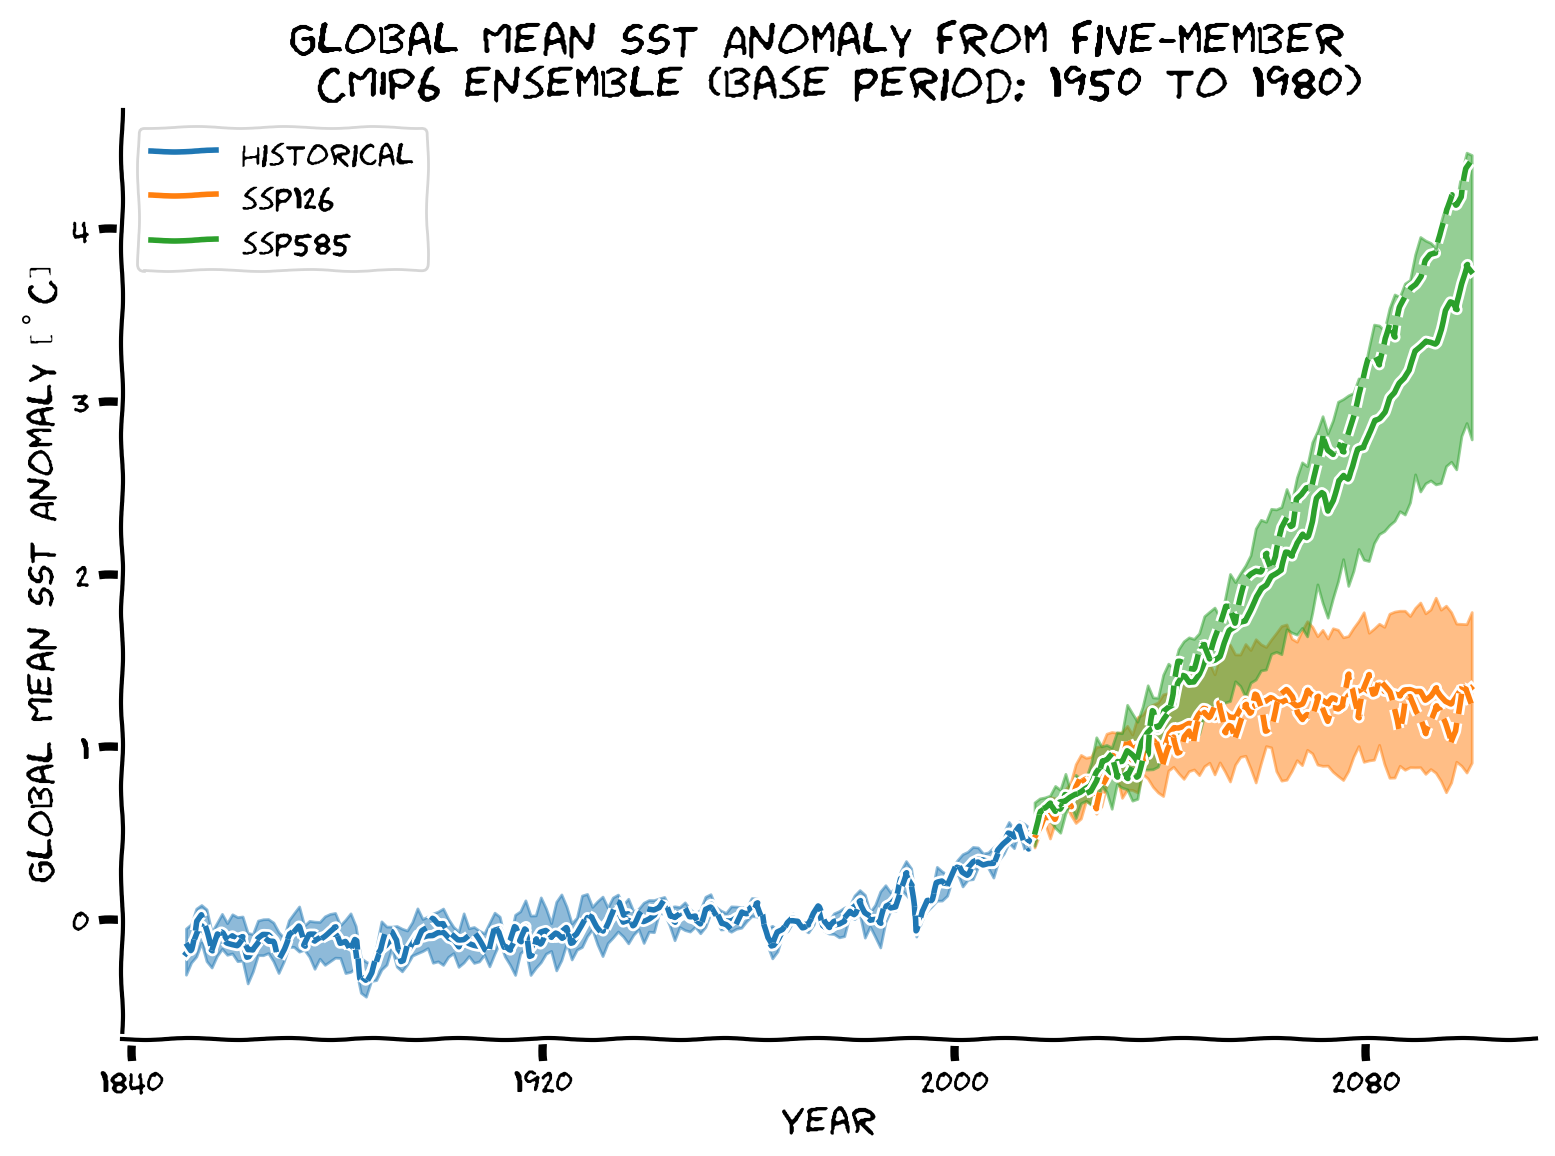

In [10]:
# to_remove solution
%matplotlib inline

with plt.xkcd():
  for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
      datasets = []
      for model in dt_gm_anomaly.keys():
          annual_sst = dt_gm_anomaly[model][experiment].ds.tos.coarsen(time=12).mean().assign_coords(source_id=model)
          datasets.append(annual_sst.sel(time=slice(None, '2100')).load()) # the french model has a long running member for ssp126 
      da = xr.concat(datasets, dim='source_id', join='override').squeeze()
      x = da.time.data
      # Calculate the lower bound of the likely range
      da_lower = da.squeeze().quantile(0.17, dim='source_id') 
      # Calculate the upper bound of the likely range
      da_upper = da.squeeze().quantile(0.83, dim='source_id') 
      plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color)
      # Calculate the multi-model mean at each time within each experiment
      da.mean('source_id').plot(color=color, label=experiment,) 
      # Calculate the multi-model median at each time within each experiment
      da.squeeze().quantile(0.5, dim='source_id').plot(color=color, linestyle='dashed',) 
  plt.title('Global Mean SST Anomaly from five-member \n CMIP6 ensemble (base period: 1950 to 1980)')
  plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
  plt.xlabel('Year')
  plt.legend()

  plt.show()

## Post-figure question

1.   What does this figure tell you about how the multi-model uncertainty compares to projected physical changes in the global mean SST? 
2.   Is this the same for both scenarios?
3.   For a 5-model ensemble like this, how do the *likely* ranges specifically relate to the 5 indivudual model temperatures at a given time?